This notebook and the data used in these examples come from the [D-Lab's GitHub repository](https://github.com/dlab-berkeley/Python-Machine-Learning-Fundamentals).  I have added some additional examples and exercises, so the version of the notebook we are using is available in this [GitHub repository](https://github.com/cbrownley/NYU-Python-Workshop).

We will be opening and running these notebooks in [Google Colab](https://colab.research.google.com) to avoid needing to install packages locally, but if you want to run these notebooks locally you are welcome to [install Python](https://www.anaconda.com) on your computer and [clone this repo](https://www.atlassian.com/git/tutorials/setting-up-a-repository/git-clone).  (Note: this notebook assumes that the data files are in a directory named `data/`, found within your current working directory, if they are not specified with a URL.)

# Regression

Whereas with classification we use a set of features (or independent variables) to predict a discrete target (aka dependent variable), in regression we are trying to predict a continuous target (i.e. a real valued number).

# 1) Loading and Preprocessing

For this regression tutorial we will use a dataset from UCI's machine learning repository ([link](http://archive.ics.uci.edu/ml/datasets/heart+disease)) containing medical information about heart disease patients.  While it was primarily used to predict heart attacks, we will use the predictor variables (aka features) to predict the age of each patient. 

## Load Data

Instead of being a built-in `sklearn` dataset, the heart disease dataset is stored in a `.csv` file, so we'll use `pandas` to load it. This dataset will require some preprocessing, which we will do using `sklearn` estimators and pipelines.

First, let's import some packages we'll need. We'll only import the specific `sklearn` estimators and functions one at a time, as needed, as is convention with `sklearn`.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in the heart disease dataset using `pandas`.

In [22]:
heart_url = 'https://raw.githubusercontent.com/cbrownley/NYU-Python-Workshop/main/data/heart.csv'

data = pd.read_csv(heart_url)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Those variable names are not the most informative. Below is the information on each of these variables from the UCI machine learning repository's [website](http://archive.ics.uci.edu/ml/datasets/heart+disease):
1. **age**: age in years 
2. **sex**: sex (1 = male; 0 = female) 
3. **cp**: chest pain type 
    1. Value 1: typical angina 
    2. Value 2: atypical angina 
    3. Value 3: non-anginal pain 
    4. Value 4: asymptomatic 
4. **trestbps**: resting blood pressure (in mm Hg on admission to the hospital) 
5. **chol**: serum cholesterol in mg/dl 
6. **fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. **restecg**: resting electrocardiographic results 
    1. Value 0: normal 
    2. Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    3. Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. **thalach**: maximum heart rate achieved 
9. **exang**: exercise induced angina (1 = yes; 0 = no) 
10. **oldpeak** = ST depression induced by exercise relative to rest 
11. **slope**: the slope of the peak exercise ST segment 
    1. Value 1: upsloping 
    2. Value 2: flat 
    3. Value 3: downsloping 
12. **ca**: number of major vessels (0-3) colored by flourosopy 
13. **thal**: 
    1. Value 3: normal
    2. Value 6: fixed defect
    3. Value 7: reversable defect 
14. **num**: diagnosis of heart disease (angiographic disease status) 
    1. Value 0: < 50% diameter narrowing 
    2. Value 1: > 50% diameter narrowing 

Some of these variables are categorical (or discrete), and others continuous (or numerical). Let's make a list of the categorical variable names to be used later on in the preprocessing.

In [23]:
# Define the variable names that are categorical for use later
cat_var_names = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']

## Categorical Data Processing

This heart disease dataset contains both categorical and continuous features, which will each need to be preprocessed in different ways. We'll start with the categorical features. First we'll want to handle any missing data, and then transform the categorical variables into indicator variables (which are either 0 or 1).

### Imputation (Missing Values)

Imputation is the name given to the preprocessing step that transforms missing values. When dealing with missing categorical values we'll want to convert them all into a special extra category called something unique, like `"MISSING"` or `-1`. To do that we'll use the `SimpleImputer` to assign a constant value to all missing values, in this case we'll use `-1`.

In [24]:
from sklearn.impute import SimpleImputer

imputer_cat = SimpleImputer(missing_values=np.nan, 
                            strategy='constant', 
                            fill_value=-1, 
                            copy=True)

Since this dataset doesn't actually have any missing values, we'll make a copy of the dataset and add a few missing values to see how imputation works in practice.

**NOTE** Because all `sklearn` estimators (including `SimpleImputer`) require 2D arrays to be passed in, we'll need to put the column name we want into a list `[]`, to get a `DataFrame` with a single column, instead of a `Series`.

In [25]:
cp_missing = data[['cp']].copy()

cp_missing.iloc[:5] = np.nan

We just set our first 6 values in our cp column as NaN (not a number), a common representation of missing data in python.

In [26]:
cp_missing.head(n=10)

,cp
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,0.0
6,1.0
7,1.0
8,2.0
9,2.0


Now we'll use this imputer to replace all occurances of `np.nan` (which are assignedn to missing values by default in pd.read_csv) to `-1` in the `cp` column of our `DataFrame`. This will also make a copy of the column.

In [27]:
cp_imp = imputer_cat.fit_transform(cp_missing)

np.unique(cp_imp)

array([-1.,  0.,  1.,  2.,  3.])

### One-Hot-Encoding

Many machine learning algorithms require that categorical data be encoded numerically in some fashion. One-hot-encoding creates `k` new variables for a single categorical variable with `k` categories (or levels), where each new variable is coded with a `1` for the observations that contain that category, and a `0` for each observation that doesn't. 

Let's use the `OneHotEncoder` from `sklearn` to transform the `cp` variable we just imputed into `k` (4 valid values in this case) one-hot-encoded variables.

In [82]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False)

In [83]:
cp_ohe = ohe.fit_transform(cp_imp)

cp_ohe.shape

(303, 5)

In [84]:
cp_ohe

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

Since one of the possible values that `cp` can take is `-1` (which we just replaced `np.nan` with), the OneHotEncoder will create an indicator variable for that value too. We don't want that variable in our models, so we'll remove the first column, which is where that variable exists (since it's the smallest value).

**NOTE**: If your categorical variable has a valid value of `-1`, then you should make your imputation value smaller than the smallest valid value to avoid confusion.

In [85]:
cp_ohe = cp_ohe[:,1:]

cp_ohe.shape

(303, 4)

In [86]:
cp_ohe

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

And to verify that it worked, let's look at the first value (which was missing) and the 6th value.

In [87]:
print('First value (missing)')
cp_imp[0], cp_ohe[0,:]

First value (missing)


(array([-1.]), array([0., 0., 0., 0.]))

In [88]:
print('6th value (not missing)')
cp_imp[5], cp_ohe[5,:]

6th value (not missing)


(array([0.]), array([1., 0., 0., 0.]))

### [OPTIONAL] Using `pandas`

Optionally you can use `pandas` to do one-hot-encoding. The problem with this, as we'll see later, is that we cannot include this into a `sklearn` pipeline, which will be a useful thing to do.

In [89]:
data_ohe = pd.get_dummies(data, columns=['cp'])

data.shape, data_ohe.shape

((303, 14), (303, 17))

In [96]:
data_ohe.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,63,1,145,233,1,0,150,0,2.3,0,0,1,1,0,0,0,1
1,37,1,130,250,0,1,187,0,3.5,0,0,2,1,0,0,1,0
2,41,0,130,204,0,0,172,0,1.4,2,0,2,1,0,1,0,0
3,56,1,120,236,0,1,178,0,0.8,2,0,2,1,0,1,0,0
4,57,0,120,354,0,1,163,1,0.6,2,0,2,1,1,0,0,0


### Dummy Encoding

When using some machine learning alorithms, such as linear regression, ridge regression and elastic net regression, we can run into the so-called ["Dummy Variable Trap"](https://www.algosome.com/articles/dummy-variable-trap-regression.html) when using One-Hot-Encoding on multiple categorical variables within the same set of features. This occurs because each set of one-hot-encoded variables can be added together across columns to create a single column of all `1`s, and so are multi-colinear when multiple one-hot-encoded variables exist within a given model.

To resolve this, we can simply add an intercept term to our model (which is all `1`s) and remove the first one-hot-encoded variable for each categorical variables, resulting in `k-1` so-called "Dummy Variables". 

Unfortunately `sklearn` doesn't allow us to do this automatically, so we'll create a new Estimator here which will do this (courtesy of [here](https://stackoverflow.com/questions/44864408/removing-columns-with-sklearns-onehotencoder)).

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin
class DummyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.encoders = []
        self.n_encoders = 0
        super().__init__()
        
    def transform(self, X):
        assert(self.n_encoders == X.shape[1])
        cols = []
        for c, ohe in enumerate(self.encoders):
            if -1 in ohe.categories_[0]:
                col_remove = 2
            else:
                col_remove = 1
            cols.append(ohe.transform(X[:,c].reshape(-1,1))[:,col_remove:])
        return np.concatenate(cols, axis=1)

    def fit(self, X, y=None, **fit_params):
        self.n_encoders = X.shape[1]
        for c in range(self.n_encoders):
            ohe = OneHotEncoder(categories='auto', handle_unknown='error', sparse=False)
            ohe.fit(X[:,c].reshape(-1,1))
            self.encoders.append(ohe)
        return self

Now we can use this estimator just as the `OneHotEncoder` estimator:

In [92]:
dummy_e = DummyEncoder()

cp_dummy = dummy_e.fit_transform(cp_imp)

cp_dummy.shape

(303, 3)

In [94]:
cp_dummy[:10]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

We can see that now we only have 3 Dummy Variables, not 4 one-hot-encoded variables. Great!

### [OPTIONAL] Using `pandas` again

Optionally, we can use the `pd.get_dummies` function to create Dummy Variables by doing the same as before, but setting the optional parameter `drop_first=True`. Again, we can't use this within a `sklearn` pipeline, so it is not as useful as it might appear.

In [95]:
data_dummy = pd.get_dummies(data, columns=['cp', 'restecg', 'slope'], drop_first=True)

data.shape, data_dummy.shape

((303, 14), (303, 18))

In [97]:
data_dummy.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,thal,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2
0,63,1,145,233,1,150,0,2.3,0,1,1,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,0,2,1,0,1,0,1,0,0,0
2,41,0,130,204,0,172,0,1.4,0,2,1,1,0,0,0,0,0,1
3,56,1,120,236,0,178,0,0.8,0,2,1,1,0,0,1,0,0,1
4,57,0,120,354,0,163,1,0.6,0,2,1,0,0,0,1,0,0,1


### Create a Pipeline

`Pipeline`s in `sklearn` allow us to combine multiple estimators in a row for quick, easy preprocessing. They have the advantage of allowing us to `fit` the preprocessing estimators to our `train` data, and then `transform` both the `train` and `test` data (or any other data!). This is useful in several scenarios, both for categorical and continuous data. 

Imagine the case where we have a categorical variable that has many different categories, one of which only appears in the `train` data. If we used separate dummy or one-hot encoders to create indicator variables for the `train` and `test` independently, then the test data would have one less indicator variable, and perhaps the indicator variables created for the `test` set would exist in the wrong order relative to those in the `train` set.

Let's have a look at how to create a pipeline for preprocessing our categorical variables.

In [98]:
from sklearn.pipeline import Pipeline

pipeline_cat = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                    strategy='constant', 
                                    fill_value=-1, 
                                    copy=True)),
                         ('dummy', DummyEncoder())])

pipeline_cat.fit_transform(data[['cp']]).shape

(303, 3)

## Continuous Data Preprocessing

Preprocessing continuous data requires different steps than categorical data. We'll still want to impute continuous data, but here we use the mean, median, or even more complex methods to make guesses at the missing data values. We don't need to create indicator variables, instead we need to normalize our variables, which helps improve performance of many machine learning models.

### Imputation (Missing Values)

Here we'll impute any missing values using the average, or mean, of all the data that does exist, as that's the best guess for a data point if all we have is the data itself. To do this we'll use the same `SimpleImputer` as before, just giving it different arguments.

In [99]:
imputer_cont = SimpleImputer(missing_values=np.nan, 
                             strategy='mean', 
                             copy=True)

oldpeak_imp = imputer_cont.fit_transform(data[['oldpeak']])

oldpeak_imp.shape

(303, 1)

### Normalization

[Normalization](https://en.wikipedia.org/wiki/Normalization_(statistics)) is a transformation that puts data into some known "normal" scale. We use normalization to improve the performance of many machine learning algorithms (see [here](https://en.wikipedia.org/wiki/Feature_scaling)). There are many forms of normalization, but perhaps the most useful to machine learning algorithms is called the "z-score" also known as the standard score. 

To z-score normalize the data, we simply subtract the mean of the data, and divide by the standard deviation. This results in data with a mean of `0` and a standard deviation of `1`.

We'll use the `StandardScaler` from `sklearn` to do normalization.

In [100]:
from sklearn.preprocessing import StandardScaler

norm_e = StandardScaler()

oldpeak_norm = norm_e.fit_transform(oldpeak_imp)

oldpeak_norm.mean(), oldpeak_norm.std()

(2.3450255305613868e-17, 1.0)

### Create a Pipeline

Now let's create a second pipeline for the continuous variables using the imputation and normalization estimators.

In [101]:
pipeline_cont = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                     strategy='mean', 
                                     copy=True)), 
                          ('norm', StandardScaler())])

oldpeak_out = pipeline_cont.fit_transform(data[['oldpeak']])

oldpeak_out.mean(), oldpeak_out.std()

(2.3450255305613868e-17, 1.0)

## Combine it all together

Now let's combine what we've learned to preprocess the entire dataset. 

### Separate `X` and `y`

While imputation is useful for features, it doesn't make sense to impute the output variable. Let's just remove any rows from the data with missing output variable values.

In [102]:
data.dropna(axis=0, subset=['age'], inplace=True)

Turns out there wasn't any missing data. Regardless, this is an important step to do just in case there is missing data!

Now we can extract the output variable `age` from the `DataFrame` to make the `X` and `Y` variables. We use a capital `X` to denote it is a `matrix` or 2-D array, and use a lowercase `y` to denote that it is a `vector`, or 1-D array.

In [103]:
X = data.drop(columns='age')

y = data['age'].astype(np.float64)

X.shape, y.shape

((303, 13), (303,))

In [154]:
X.head()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Train/Test split

Now we'll want to split our dataset into `train` and `test` data as we did for the classification tasks earlier. This will let us fit the preprocessing steps to the `train` data and apply it to both the `train` and `test` datasets. 

First we need to: **set the random seed!**

In [104]:
np.random.seed(10)

Now we can use the train_test_split function to split the entire dataset into 75% `train` data and 25% `test` data:

In [105]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.25)

print('XTrain shape:', X_train_raw.shape, 'YTrain shape:', y_train_raw.shape, '\n')
print('XTest shape:', X_test_raw.shape, 'YTest shape:', y_test_raw.shape)

XTrain shape: (227, 13) YTrain shape: (227,) 

XTest shape: (76, 13) YTest shape: (76,)


### `ColumnTransformer` for Combined Preprocessing

While we could apply the pipelines we've made above to each of the columns separately, `sklearn` provides an easier way to apply estimators differntially to different `DataFrame` columns. It's called the `ColumnTransformer` and here's how it works.

First, we need to make boolean masks for which columns (features) are categorical and which are continuous.

In [106]:
cat_vars = np.array([True if col in cat_var_names else False for col in X.columns])

cont_vars = ~cat_vars

cat_vars, cont_vars

(array([ True,  True, False, False,  True,  True, False,  True, False,
         True, False,  True, False]),
 array([False, False,  True,  True, False, False,  True, False,  True,
        False,  True, False,  True]))

Now we create a `ColumnTransformer` by providing it with a list of 3-element tuples, with the format:

    (<TRANSFORMER_NAME>, <TRANSFORMER>, <COLUMNS>)

We'll create two different transformer pipelines, each of which contain two transformers (or estimators). The first will do constant imputation and dummy variable coding on categorical variables, and the second will do mean imputation and normalization on continuous variables. 

In [108]:
from sklearn.compose import ColumnTransformer

pipeline_cat_com = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                                      strategy='constant', 
                                                      fill_value=-1, 
                                                      copy=True)),
                             ('dummy', DummyEncoder())])

pipeline_cont_com = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                                       strategy='mean', 
                                                       copy=True)), 
                              ('norm', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', pipeline_cat_com, cat_vars), 
                                               ('cont', pipeline_cont_com, cont_vars)])

We'll also need to create a `StandardScaler` to scale the y (age) back and forth:

In [109]:
age_scaler = StandardScaler()

### Fit and Transform the `train` Data

We'll want to first fit and transform the training data, so that the dummy variable encoding and z-scoring (mean & standard deviation) are calculated based on the training data. 

In [110]:
X_train = preprocessor.fit_transform(X_train_raw)

X_train_raw.shape, X_train.shape

((227, 13), (227, 19))

In [111]:
y_train = age_scaler.fit_transform(y_train_raw.values.reshape(-1,1))

y_train.mean(), y_train.std()

(-7.042824473393064e-17, 0.9999999999999999)

### Transform the `test` Data

Now simply transform the test data, using the fit values from the training data.

In [112]:
X_test = preprocessor.transform(X_test_raw)

X_test_raw.shape, X_test.shape

((76, 13), (76, 19))

In [113]:
y_test = age_scaler.transform(y_test_raw.values.reshape(-1,1))

y_test.mean(), y_test.std()

(0.02149068640878707, 0.9768591753400121)

Finally, let's save out this data, and the preprocessing pipelines, for later use.

In [114]:
# In Google Colab
np.savez('/content/heart_preproc.npz', 
         X_test=X_test, y_test=y_test, 
         X_train=X_train, y_train=y_train,
         preprocessor=preprocessor, 
         age_scaler=age_scaler)

# In GitHub and personal computer
# np.savez('data/heart_preproc.npz', 
#         X_test=X_test, y_test=y_test, 
#         X_train=X_train, y_train=y_train,
#         preprocessor=preprocessor, 
#         age_scaler=age_scaler)

In scikit-learn, as soon as you have `X_train`, `X_test`, `y_train`, and `y_test`, everything else is just a matter of choosing your model and the parameters for it.  But this should not be trivialized, selecting models and each model's parameters is *very* important.  While we will not cover it here, choosing an effective model and its parameters is a core skill of applying machine learning algorithms, and can have dramatic affects on a model's predictive performance.

# 2) Building models

The syntax in scikit-learn does not change for each model, only the parameters. Also, it is not very different from the classification model syntax.  Examples of various models are given below:

## Linear Models

### GLM - Ordinary Least Squares Linear Regression

We'll start with a basic [OLS linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression):

In [115]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression(n_jobs=1)  # CPUs to use

In [116]:
lin_reg.fit(X_train, y_train)

LinearRegression(n_jobs=1)

We can see how well we fit the training set. When fitting classification models, the `.score` method would return mean accuracy. For regression models `.score()` returns the amount of variance in the output variable that can be explained by the model predictions. This is known as $R^2$, or R-squared. There are many other performance metrics that can be used when predicting continuous variables.

Let's look at the $R^2$ for the training data:

In [117]:
print('Training data R^2: %.03f' % (lin_reg.score(X_train, y_train)))

Training data R^2: 0.293


And the test data. 

In [118]:
print('Test data R^2: %.03f' % (lin_reg.score(X_test, y_test)))

Test data R^2: 0.327


### GLM - Ridge Regression

If you have many features, you may want to consider regularization. 

Instead of minimizing least squares loss: 
$$ L(\beta) = \sum_i^n (y_i - \hat y_i)^2 $$ 

In ridge regression we additionally penalize the coefficients and minimize this: 

$$ L(\beta) = \sum_i^n (y_i - \hat y_i)^2  + \alpha \sum_j^p \beta^2 $$ 

Ridge regression takes a **hyerparameter**, called alpha (sometimes lambda). This hyperparameter indicates how much regularization should be done. In other words, how much to care about the coefficient penalty term vs how much to care about the sum of squared errors term. The higher the value of alpha the more regularization, and the smaller the resulting coefficients will be. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) for more.

If we use an `alpha` value of `0` then we get the same solution as the OLS regression done above. Let's prove that.

In [119]:
from sklearn import linear_model

ridge_reg = linear_model.Ridge(alpha=0,        # regularization
                               solver='auto',  # options = auto, svd, cholesky, lsqr, sparse_cg, sag
                               random_state = 10)  

model = ridge_reg.fit(X_train, y_train)

In [120]:
print('Test R^2: %.03f' % (model.score(X_train, y_train)))

print('Test R^2: %.03f' % (model.score(X_test, y_test)))

Test R^2: 0.293
Test R^2: 0.327


Generally we don't know what the best value hypterparameter values should be, and so we need to use some form of cross-validation to determine that value. `RidgeCV` does just that. It fits a ridge regression model by first using cross-validation to find a good value of alpha. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) for more.

We specify the alphas we want the estimator to try. It's often a good idea to use a logarithmic space to allow for finer grained search in smaller values. Let's create the alphas list we want to use.

In [121]:
alphas = np.logspace(-2, 1.2, 20)
alphas

array([1.00000000e-02, 1.47374062e-02, 2.17191140e-02, 3.20083405e-02,
       4.71719914e-02, 6.95192796e-02, 1.02453386e-01, 1.50989716e-01,
       2.22519677e-01, 3.27936286e-01, 4.83293024e-01, 7.12248558e-01,
       1.04966963e+00, 1.54694077e+00, 2.27978944e+00, 3.35981829e+00,
       4.95150067e+00, 7.29722764e+00, 1.07542208e+01, 1.58489319e+01])

In [128]:
def extrema_np(arr, round=False, decimals=2):
    if round == True:
        return np.round(np.max(arr), decimals) , np.round(np.min(arr), decimals)
    else:
        return np.max(arr), np.min(arr)


extrema_np(alphas, round=True)

(15.85, 0.01)

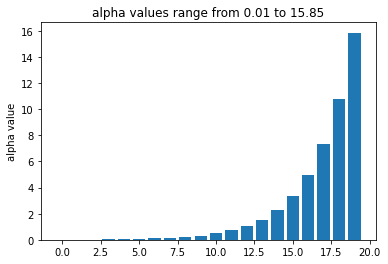

In [130]:
plt.bar(range(len(alphas)), alphas)
plt.ylabel('alpha value')
plt.title('alpha values range from {} to {}'.format(extrema_np(alphas, round=True)[1], 
                                                    extrema_np(alphas, round=True)[0]));

By default the `RidgeCV` uses "Leave One Out Cross Validation" (LOOCV). Let's fit the Ridge model

In [132]:
ridge_cv = linear_model.RidgeCV(alphas=alphas, 
                                store_cv_values=True)

ridge_cv.fit(X_train, y_train)

print('Selected Alpha:', np.round(ridge_cv.alpha_, 2))

Selected Alpha: 15.85


Let's see how it did relative to OLS.

In [133]:
print('Train R^2: %.03f' % (ridge_cv.score(X_train, y_train)))

print('Test R^2: %.03f' % (ridge_cv.score(X_test, y_test)))

Train R^2: 0.287
Test R^2: 0.340


Looks like it did a bit better than using regular OLS! We can look at a plot showing the model performance (In mean squared error, or MSE) as a function of alpha size. Let's see

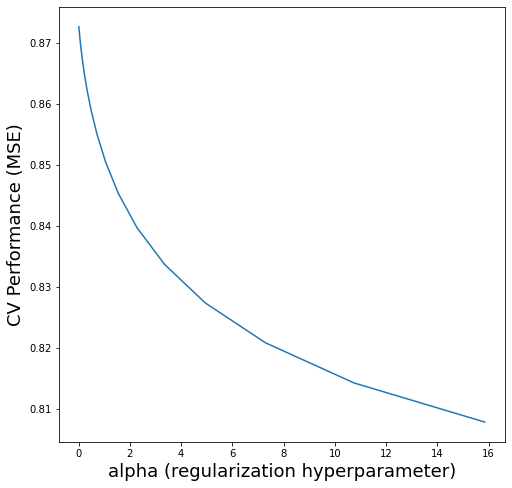

In [134]:
plt.figure(figsize=(8,8))
plt.plot(alphas, ridge_cv.cv_values_.mean(axis=0).reshape(-1))
plt.xlabel('alpha (regularization hyperparameter)', fontsize=18)
plt.ylabel('CV Performance (MSE)', fontsize=18);

### GLM - Elastic Net Regression

Elastic Net regression is another form of regularized regression that uses a combination of an L2 penalization (same as Ridge) and an L1 penalization (same as Lasso). See [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) for more.

In [138]:
elastic_reg = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                        n_alphas=100,
                                        copy_X=True,
                                        random_state=10,
                                        cv=3,
                                        selection='cyclic')  # or random, which converges faster

model = elastic_reg.fit(X_train, y_train.ravel())

print('l1 Ratio:', np.round(elastic_reg.l1_ratio_, 2))
print('alpha:',    np.round(elastic_reg.alpha_, 3))
print('Test R^2:', np.round(model.score(X_test, y_test), 3))

l1 Ratio: 0.95
alpha: 0.029
Test R^2: 0.337


### Support Vector Regression

Support Vector Machines (SVMs) are popular and effective models that find the data points of each class that are closest to each other (the support vectors) and then find a hyperplane half way between those points. SVMs can be used in a linear fashion (as is done below) or by applying a non-linear kernel function. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) for more. 

In [139]:
from sklearn import svm

sv_reg = svm.SVR(kernel='linear',  # linear, poly, rbf, sigmoid, precomputed
                 degree=3,         # only used for 'poly' above
                 gamma='auto',     # kernal coeff, default auto is 1/n_features
                 C=1.0)

model = sv_reg.fit(X_train, y_train.ravel())

print(np.round(model.score(X_test, y_test), 3))

0.324


## Non-Linear Models

With some of the non-linear models below we won't be fitting a bias term (or intercept) with the models, and so using dummy encoded categorical variables is inappropriate. Instead we'll use one-hot encoding for these models. Let's create a second pipeline that will preprocess our `X` data using one-hot encoding.

In [140]:
pipeline_cat_com2 = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                                       strategy='constant', 
                                                       fill_value=-1, 
                                                       copy=True)), 
                              ('ohe', OneHotEncoder(categories='auto'))])

pipeline_cont_com2 = Pipeline([('impute', SimpleImputer(missing_values=np.nan, 
                                                        strategy='mean', 
                                                        copy=True)), 
                               ('norm', StandardScaler())])

preprocessor_ohe = ColumnTransformer(transformers=[('cat', pipeline_cat_com2, cat_vars),
                                                   ('cont', pipeline_cont_com2, cont_vars)])

In [141]:
X_train_ohe = preprocessor_ohe.fit_transform(X_train_raw)

X_test_ohe  = preprocessor_ohe.transform(X_test_raw)

### K-nearest neighbors regression

K Nearest Neighbors uses the averaged values of the `k` data points that are closest to the predicted value in the feature space. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) for more.

In [142]:
from sklearn import neighbors

knn_reg = neighbors.KNeighborsRegressor(n_neighbors=20,
                                        weights='uniform', # distance weights points by inverse of their distance
                                        algorithm='auto',  # ball_tree, kd_tree, brute
                                        leaf_size=30) # for tree algorithms

model = knn_reg.fit(X_train_ohe, y_train)

print(np.round(model.score(X_test_ohe, y_test), 3))

0.218


### Random Forest Regression

We've already used random forests for classification in the previous section, and here we'll use them for regression. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) for more.

In [145]:
from sklearn import ensemble

rf_reg = ensemble.RandomForestRegressor(n_estimators=10,  # number of trees
                                        criterion='squared_error',  # how to measure fit
                                        max_depth=None,  # how deep tree nodes can go
                                        min_samples_split=2,  # samples needed to split node
                                        min_samples_leaf=1,   # samples needed for a leaf
                                        min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                        max_features='auto',  # max feats
                                        max_leaf_nodes=None,  # max nodes
                                        n_jobs=1,  # how many to run parallel
                                        random_state=10)

model = rf_reg.fit(X_train_ohe, y_train.ravel())

print(np.round(model.score(X_test_ohe, y_test), 3))

0.29


### Boosting - AdaBoost Regression

You used an adaptive boosting, or AdaBoost, estimator to do classification in the challenge question of the previous section. Here we'll use it for regression. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) for more.

In [146]:
ab_reg = ensemble.AdaBoostRegressor(base_estimator=None,  # default is DT 
                                    n_estimators=50,      # number to try before stopping
                                    learning_rate=1.0,    # decrease influence of each additional estimator
                                    random_state=10,
                                    loss='linear')  # also square, exponential


model = ab_reg.fit(X_train_ohe, y_train.ravel())
print(np.round(model.score(X_test_ohe, y_test), 3))

0.369


## 3) Grid Search

As with classfication, you can also use grid search on regression models.

In [147]:
param_grid = {'n_estimators': range(40,80,5),
              'learning_rate': np.arange(0.5, 1.0, .1)}

In [148]:
from sklearn.model_selection import GridSearchCV

model_reg = GridSearchCV(ensemble.AdaBoostRegressor(base_estimator=None, 
                                                    random_state=10, 
                                                    loss='linear'), 
                         param_grid, 
                         cv=3)

model_reg.fit(X_train_ohe, y_train.ravel());

In [149]:
best_index = np.argmax(model_reg.cv_results_["mean_test_score"])

print(model_reg.cv_results_["params"][best_index])

print('Best CV R^2:', np.round(max(model_reg.cv_results_["mean_test_score"]), 3))

print('Test R^2:', np.round(model_reg.score(X_test_ohe, y_test), 3))

{'learning_rate': 0.5, 'n_estimators': 45}
Best CV R^2: 0.151
Test R^2: 0.364


## 4) Prediction

Great, not a bad fit! Let's say we come upon a new patient and want to guess their age. Here are the feature values:

In [150]:
random_patient_raw = np.array([1, 2, 135, 242, 1, 0, 167, 0, 2.1, 1, 0, 2, 1]).reshape(1,-1)

random_patient_raw.shape

(1, 13)

Now comes the real power of the preprocessing pipeline that we created earlier! We can simply run transform on it, and we have a preprocessed observation ready to predict.

In [176]:
random_patient_raw = pd.DataFrame(dict(zip(list(X.columns), 
                                           [1, 2, 135, 242, 1, 0, 167, 0, 2.1, 1, 0, 2, 1])), 
                                  index=range(1))

random_patient_raw

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,2,135,242,1,0,167,0,2.1,1,0,2,1


In [177]:
random_patient = preprocessor.transform(random_patient_raw)
random_patient

array([[ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.21987091, -0.12478192,
         0.73728402,  0.95575465, -0.6875383 ,  0.86380197]])

Now let's use our model to predict!

In [178]:
age_z = lin_reg.predict(random_patient)
age_z

array([[-0.23259791]])

Huh, the value our model predicted is a small negative number, why's that? It's because we've normalized (z-scored) all of the age data when fitting the model, so the predicted values are in z-scored units. Let's use the `age_scaler` to reverse transform the z-scored age back into original scale (years) age.

In [179]:
pred_age = age_scaler.inverse_transform(age_z)
np.round(pred_age, 1)

array([[52.2]])

## Challenge

Choose three algorithms and use grid search to determine the best model for this dataset. Make sure to base your decision on model performance on the out-of-sample test set data.